# "Brain Tumor Detection using DenseNet Model" 

A DenseNet (Dense Convolutional Network) is a type of convolutional neural network architecture that connects each layer to every other layer in a feed-forward fashion. This architecture was introduced to improve the flow of information and gradients throughout the network, making it more efficient and effective.

steps for proprocessing ,training evaluation an effective Deep Learning model for brain tumor detection. Here’s a general workflow you can follow:


# 1. Data Collection
Ensure you have a sufficient amount of labeled brain MRI images. Common datasets include:

BRATS (Brain Tumor Segmentation): Available through the Medical Decathlon or the BRATS challenges.
Kaggle Datasets: Various MRI datasets available on Kaggle. https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

# DENSE NET Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np


# Input Shape

In [ ]:
# Define input shape (assuming 224x224 RGB images)
input_shape = (224, 224, 3)
num_classes = 2

# Proprocessing the image 

In [ ]:
# Function to load and preprocess images
def load_images_from_folder(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['Not Tumor', 'Tumor']):
        label_path = os.path.join(folder_path, category)
        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))  # Resize image to 224x224 pixels
                img = img.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)


# Load and preprocess training/validation data

In [ ]:
data_dir = 'Brain Tumor Data Set/'
train_images, train_labels = load_images_from_folder(os.path.join(data_dir, 'train'))
val_images, val_labels = load_images_from_folder(os.path.join(data_dir, 'validation'))

# verify the loaded dateset shapes

In [ ]:
# Print shapes of loaded datasets
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)

# Training and validation with augmentation

In [ ]:
# Define data generators for training and validation with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()

# Training the image in batch 32 or 64 or 128

In [ ]:
# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)

# Flow validation images in batches of 32 using val_datagen generator
val_generator = val_datagen.flow(val_images, val_labels, batch_size=32)


# Funtional API

In [ ]:
# Build the model using Functional API
inputs = Input(shape=input_shape)
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=inputs)


# Fine-tune denseNet to get batter results.

In [ ]:
# Fine-tune DenseNet121 - Unfreeze some layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile the Fine_tune DenseNet121 Model 

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [ ]:
# Display model summary
model.summary()

 module computes weights for each class in a dataset, 
 which can be used to handle imbalanced datasets during model training

In [ ]:
# Compute class weights and convert to dictionary
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))

# Defining the Callback:
the learning rate will be adjusted.

In [ ]:
# Define learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)


# model Training

In [ ]:
# Train the model
history = model.fit(train_generator,
                    epochs=10,  # Increase epochs if needed
                    validation_data=val_generator,
                    class_weight=class_weights_dict,
                    callbacks=[reduce_lr])


# Model Evaluation

In [ ]:
# Evaluate the model
val_loss, val_acc = model.evaluate(val_generator, verbose=2)
print("\nValidation Accuracy:", val_acc)


# Graph Plot

In [ ]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Model Prediction

In [ ]:
# Make predictions
predictions = model.predict(val_images)
predicted_labels = np.argmax(predictions, axis=1)


In [ ]:
# Print classification report
print("\nClassification Report:")
print(classification_report(val_labels, predicted_labels))


# Confusion Matrics:

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(val_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Tumor', 'Tumor'], yticklabels=['Not Tumor', 'Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Save The Model file in H5 format

Training images shape: (714, 224, 224, 3)
Training labels shape: (714,)
Validation images shape: (714, 224, 224, 3)
Validation labels shape: (714,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,418 (27.85 MB)

 Trainable params: 7,216,770 (27.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

Epoch 1/10


c:\Users\Pro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 481s 17s/step - accuracy: 0.6614 - loss: 0.7130 - val_accuracy: 0.7129 - val_loss: 0.6946 - learning_rate: 1.0000e-04
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 371s 16s/step - accuracy: 0.8803 - loss: 0.2863 - val_accuracy: 0.9020 - val_loss: 0.2289 - learning_rate: 1.0000e-04
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 374s 16s/step - accuracy: 0.9320 - loss: 0.1844 - val_accuracy: 0.9146 - val_loss: 0.1888 - learning_rate: 1.0000e-04
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 378s 16s/step - accuracy: 0.9412 - loss: 0.1596 - val_accuracy: 0.9496 - val_loss: 0.1263 - learning_rate: 1.0000e-04
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 372s 16s/step - accuracy: 0.9761 - loss: 0.0796 - val_accuracy: 0.9552 - val_loss: 0.1339 - learning_rate: 1.0000e-04
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 369s 16s/step - accuracy: 0.9781 - loss: 0.0772 - val_accuracy: 0.6989 - val_loss: 0.7523 - learning_rate: 1.0000e-04
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 377s 16s/step - accuracy: 0.9767 - lo

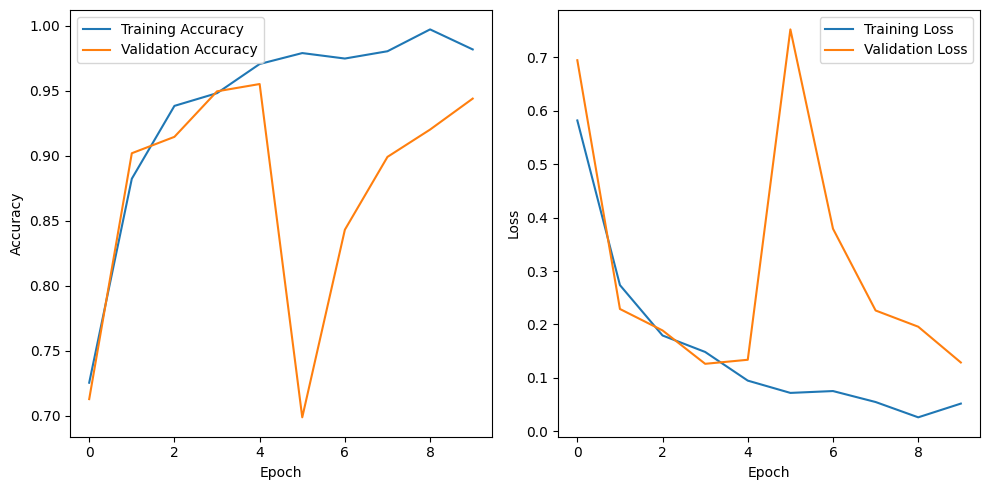

23/23 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94       340
           1       0.90      1.00      0.95       374

    accuracy                           0.94       714
   macro avg       0.95      0.94      0.94       714
weighted avg       0.95      0.94      0.94       714



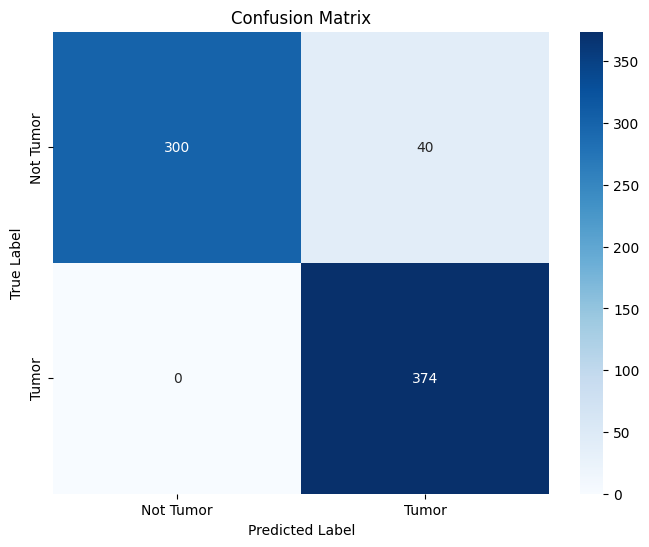

In [1]:
# Save the model in H5 format
model.save('DenseNet1_Model_brain_tumor_detection.h5')
